In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from duneanalytics import DuneAnalytics

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

In [4]:
# get Dune Analytics login credentials
MY_USERNAME = os.environ.get('DUNE_USERNAME')
MY_PASSWORD = os.environ.get('DUNE_PASSWORD')
dune = DuneAnalytics(MY_USERNAME, MY_PASSWORD)

## Input

In [5]:
chain = 'Arbitrum'

In [6]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'
qid_price_yield = 1105079 if chain == 'Arbitrum' else 1109126
qid_swap_cost = 1095373 if chain == 'Arbitrum' else 1101895
qid_claim_cost = 1092684 if chain == 'Arbitrum' else 1102122 
qid_mint_cost = 1069676 if chain == 'Arbitrum' else 1102319 

## Read Data from Dune

In [7]:
def extract_frame_from_dune_data(dune_data):    
    dd = dune_data['data']['get_result_by_result_id']
    df = pd.json_normalize(dd, record_prefix='')
    df = df.loc[:, df.columns.str.startswith('data')]
    df.columns = df.columns.str.replace('data.', '', regex=False)
    # set `day` as index
    df['date'] = pd.to_datetime(df.day.str.replace('T.*', '', regex=True))
    del df['day']
    df = df.set_index('date')
    # drop the last row cuz it may not always be a full day
    return df.iloc[:-1, :]

In [8]:
dune.login()
dune.fetch_auth_token()
 
# fetch query result
price_yield = dune.query_result(dune.query_result_id(query_id=qid_price_yield))
swap_cost = dune.query_result(dune.query_result_id(query_id=qid_swap_cost))
claim_cost = dune.query_result(dune.query_result_id(query_id=qid_claim_cost))
mint_cost = dune.query_result(dune.query_result_id(query_id=qid_mint_cost))

In [9]:
# extract data frames
df_price_yield = extract_frame_from_dune_data(price_yield)
df_eth_usd_swap_cost = extract_frame_from_dune_data(swap_cost)
df_eth_reward_claim_cost = extract_frame_from_dune_data(claim_cost)
df_eth_glp_mint_cost = extract_frame_from_dune_data(mint_cost)

In [10]:
df_price_yield = (df_price_yield[['eth_price', 'btc_price', 'glp_price', 
                                  'glp_supply', 'cumu_glp_supply', 
                                  'yield_usd', 'yield_eth']]
                      .assign(yield_per_share_usd = lambda x: x.yield_usd / x.cumu_glp_supply,
                              yield_per_share_eth = lambda x: x.yield_eth / x.cumu_glp_supply)
                 )
df_price_yield.tail()

,eth_price,btc_price,glp_price,glp_supply,cumu_glp_supply,yield_usd,yield_eth,yield_per_share_usd,yield_per_share_eth
date,,,,,,,,,
2022-07-26,"1,413.3000","21,109.5850",0.8717,"1,597,784.5698","208,091,353.0835","118,796.6490",84.0562,0.0006,0.0000
2022-07-27,"1,465.8300","21,389.6550",0.8884,"1,171,458.7841","209,262,811.8676","100,209.8284",68.3639,0.0005,0.0000
2022-07-28,"1,642.5050","23,209.9950",0.9424,"-90,047.1565","209,172,764.7111","210,351.3976",128.0674,0.0010,0.0000
2022-07-29,"1,718.5350","23,929.0350",0.9651,"4,158,839.0873","213,331,603.7984","557,325.1779",324.3025,0.0026,0.0000
2022-07-30,"1,713.5550","23,924.9650",0.9628,"1,079,906.2530","214,411,510.0514","119,846.2525",69.9401,0.0006,0.0000


In [11]:
df_eth_usd_swap_cost.tail()

,fee_bp,gas_usd
date,,
2022-07-26,44.0000,0.2122
2022-07-27,43.0000,0.1760
2022-07-28,43.0000,0.2262
2022-07-29,42.0000,0.1935
2022-07-30,42.0000,0.1227


In [12]:
df_eth_reward_claim_cost.tail()

,gas_usd
date,
2022-07-26,0.1979
2022-07-27,0.1513
2022-07-28,0.2046
2022-07-29,0.1816
2022-07-30,0.1129


In [13]:
df_eth_glp_mint_cost.tail()

,fee_bp,gas_usd
date,,
2022-07-26,17.0000,0.2430
2022-07-27,22.0000,0.2315
2022-07-28,22.0000,0.2564
2022-07-29,21.0000,0.2217
2022-07-30,20.0000,0.1429


In [14]:
end_date = np.min([df_price_yield.index[-1], df_eth_usd_swap_cost.index[-1], df_eth_reward_claim_cost.index[-1], df_eth_glp_mint_cost.index[-1]])
end_date

Timestamp('2022-07-30 00:00:00')

## Set up 

allow users to enter their own numbers and see output

In [15]:
# user input
start_date = '2021-08-31'     # date of GLP purchase, can use a date string, for example, '2022-06-15'
start_capital = 10_000              # start with this much dollars
start_reserve = 1600                # dollars for paying tx costs

In [16]:
day1 = pd.to_datetime(start_date)
day2 = day1 + pd.Timedelta(1, 'day')
day_before_end = end_date - pd.Timedelta(1, 'day')
print('Start:', start_date)
print('Day 2:', day2.strftime('%Y-%m-%d'))
print('Day before last day:', day_before_end.strftime('%Y-%m-%d'))
print('End:', end_date.strftime('%Y-%m-%d'))

Start: 2021-08-31
Day 2: 2021-09-01
Day before last day: 2022-07-29
End: 2022-07-30


In [17]:
# beginning account value before any tx 
total_value_day1 = pd.Series(start_capital + start_reserve, index=pd.Index({day1}, name='date'))
total_value_day1

date
2021-08-31    11600
dtype: int64

In [18]:
# buy GLP with capital. what's the purchase price and tx cost?
init_price = df_price_yield.loc[start_date, 'glp_price']
init_fee_bp = df_eth_glp_mint_cost.loc[start_date, 'fee_bp']
init_fee = start_capital * init_fee_bp/1e4 # platform fee
init_gas = df_eth_glp_mint_cost.loc[start_date, 'gas_usd']

# pay tx cost
capital = start_capital - init_fee 
reserve = start_reserve - init_gas # always pay gas from reserve funds

# how many shares of GLP did we buy?
init_shares = capital / init_price

print('Purchase price: ${:.3f}'.format(init_price)) 
print('Platform fee paid: ${:.3f}'.format(init_fee))
print('Gas paid: ${:.3f}'.format(init_gas))
print('Shares: {:.4f}'.format(init_shares))

Purchase price: $1.178
Platform fee paid: $11.000
Gas paid: $2.781
Shares: 8477.8148


In [19]:
res = dict() # hold output growth paths

### Assumptions

- Buy shares at day end so we earn 0 yield on the day we buy GLP and earn full yield the next day.
- Sell shares at day end so we earn full yield on the last day.
- When reinvesting rewards, reinvest today's yield at today's price. Reinvestment also happens at day end so we earn 0 yield on the newly bought shares on the same day.

## Strategy 1: Accumulate rewards and Claim once at the end and Swap to USD

In [20]:
# from day 2 until the last day
df = (df_price_yield.loc[day2:end_date, ['eth_price', 'glp_price', 'yield_per_share_eth']]
          .assign(my_glp_shares = init_shares,
                  my_yield_eth = lambda x: x.yield_per_share_eth * x.my_glp_shares,
                  my_cumu_yield_eth = lambda x: x.my_yield_eth.cumsum(),
                  my_cumu_yield_usd = lambda x: x.my_cumu_yield_eth * x.eth_price,
                  my_total_value = lambda x: x.glp_price * x.my_glp_shares + x.my_cumu_yield_usd + reserve)
     ) 
df

,eth_price,glp_price,yield_per_share_eth,my_glp_shares,my_yield_eth,my_cumu_yield_eth,my_cumu_yield_usd,my_total_value
date,,,,,,,,
2021-09-01,"3,541.3550",1.2595,0.0000,"8,477.8148",0.0100,0.0100,35.4308,"12,310.0918"
2021-09-02,"3,776.8750",1.2789,0.0000,"8,477.8148",0.0032,0.0132,49.9621,"12,489.2702"
2021-09-03,"3,919.3250",1.3158,0.0000,"8,477.8148",0.0042,0.0174,68.3221,"12,820.7740"
2021-09-04,"3,916.7200",1.3084,0.0000,"8,477.8148",0.0010,0.0184,72.0604,"12,761.3731"
2021-09-05,"3,906.1850",1.3109,0.0000,"8,477.8148",0.0010,0.0194,75.9335,"12,787.1393"
...,...,...,...,...,...,...,...,...
2022-07-26,"1,413.3000",0.8717,0.0000,"8,477.8148",0.0034,0.9810,"1,386.4811","10,374.1651"
2022-07-27,"1,465.8300",0.8884,0.0000,"8,477.8148",0.0028,0.9838,"1,442.0741","10,571.4035"
2022-07-28,"1,642.5050",0.9424,0.0000,"8,477.8148",0.0052,0.9890,"1,624.4114","11,211.2993"


In [21]:
# on the last day, what's the usd value of all the eth rewards we accumulated?
eth_rewards_value = df.loc[end_date, 'my_cumu_yield_usd']

# 1. claim all accumulated eth rewards. don't pay any fees to the platform, but need to pay gas 
fee = 0
gas = df_eth_reward_claim_cost.loc[end_date, 'gas_usd']

# 2. swap them to usd on the platform. need to pay a fee to the platform and gas 
fee += eth_rewards_value * (df_eth_usd_swap_cost.loc[end_date, 'fee_bp']/1e4)
gas += df_eth_usd_swap_cost.loc[end_date, 'gas_usd']

# update total value on last day
df.loc[end_date, 'my_total_value'] = df.loc[end_date, 'my_total_value'] - fee - gas

In [22]:
# collect the series of account values into res, don't forget beginning value
acct_value = pd.concat([total_value_day1, df.my_total_value])
print(acct_value)
name = 'Accumulate {} rewards, Claim them once on last day and Sell into USD'.format(reward_token)
res[name] = acct_value

date
2021-08-31   11,600.0000
2021-09-01   12,310.0918
2021-09-02   12,489.2702
2021-09-03   12,820.7740
2021-09-04   12,761.3731
                 ...    
2022-07-26   10,374.1651
2022-07-27   10,571.4035
2022-07-28   11,211.2993
2022-07-29   11,500.9689
2022-07-30   11,473.9123
Length: 334, dtype: float64


## Strategy 2: Claim and Sell Rewards into USD Daily

In [23]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:end_date, ['glp_price', 'yield_per_share_usd']], 
               df_eth_reward_claim_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_eth_usd_swap_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_swap', 'fee_bp': 'fee_bp_swap'})
     )
df = (df.assign(my_glp_shares = init_shares,
                # no fees are collected by the platform when we claim rewards;
                # a fee is collected by the platform everytime we swap eth to usd 
                my_yield_usd_after_fees = lambda x: x.yield_per_share_usd * x.my_glp_shares * (1-x.fee_bp_swap/1e4),
                my_cumuyield_usd_after_fees = lambda x: x.my_yield_usd_after_fees.cumsum(),
                # need to pay gas everytime we claim and everytime we swap
                reserve = lambda x: reserve - x.gas_claim.cumsum() - x.gas_swap.cumsum(),
                # finally we calculate total account value each day
                my_total_value = lambda x: x.glp_price * x.my_glp_shares + x.my_cumuyield_usd_after_fees + x.reserve
               )
     ) 
df

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_yield_usd_after_fees,my_cumuyield_usd_after_fees,reserve,my_total_value
date,,,,,,,,,,
2021-09-01,1.2595,0.0042,5.6521,30.0000,3.7922,"8,477.8148",35.3245,35.3245,"1,587.7746","12,300.5412"
2021-09-02,1.2789,0.0014,4.6788,30.0000,3.9338,"8,477.8148",12.1384,47.4630,"1,579.1619","12,468.7140"
2021-09-03,1.3158,0.0019,3.9068,30.0000,4.4772,"8,477.8148",16.4262,63.8891,"1,570.7779","12,789.9000"
2021-09-04,1.3084,0.0004,3.5039,30.0000,4.5284,"8,477.8148",3.7724,67.6615,"1,562.7456","12,722.5009"
2021-09-05,1.3109,0.0005,2.9881,30.0000,4.9703,"8,477.8148",4.0547,71.7162,"1,554.7872","12,740.4902"
...,...,...,...,...,...,...,...,...,...,...
2022-07-26,0.8717,0.0006,0.1979,44.0000,0.2122,"8,477.8148",4.8186,"2,889.0089",70.3758,"10,349.8496"
2022-07-27,0.8884,0.0005,0.1513,43.0000,0.1760,"8,477.8148",4.0423,"2,893.0512",70.0484,"10,495.2102"
2022-07-28,0.9424,0.0010,0.2046,43.0000,0.2262,"8,477.8148",8.4889,"2,901.5401",69.6176,"10,960.8267"


In [24]:
if df.reserve.loc[end_date] < 0:
    print("To implement this strategy, you need at least ${} in reserve to pay gas.".format(np.ceil(reserve + abs(df.reserve.loc[end_date]))))

In [25]:
# collect the series of account values into res, don't forget beginning value
acct_value = pd.concat([total_value_day1, df.my_total_value])
print(acct_value)
name = 'Claim and Sell {} Rewards into USD Daily'.format(reward_token)
res[name] = acct_value

date
2021-08-31   11,600.0000
2021-09-01   12,300.5412
2021-09-02   12,468.7140
2021-09-03   12,789.9000
2021-09-04   12,722.5009
                 ...    
2022-07-26   10,349.8496
2022-07-27   10,495.2102
2022-07-28   10,960.8267
2022-07-29   11,174.8358
2022-07-30   11,159.9789
Length: 334, dtype: float64


## Strategy 3: Reinvest Rewards into GLP Daily

In [26]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:end_date, ['glp_price', 'yield_per_share_usd']], df_eth_reward_claim_cost, 
               left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_eth_glp_mint_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_mint', 'fee_bp': 'fee_bp_mint'})
     )
df

,glp_price,yield_per_share_usd,gas_claim,fee_bp_mint,gas_mint
date,,,,,
2021-09-01,1.2595,0.0042,5.6521,30.0000,9.2498
2021-09-02,1.2789,0.0014,4.6788,30.0000,9.5408
2021-09-03,1.3158,0.0019,3.9068,30.0000,8.8557
2021-09-04,1.3084,0.0004,3.5039,30.0000,9.4012
2021-09-05,1.3109,0.0005,2.9881,30.0000,8.8273
...,...,...,...,...,...
2022-07-26,0.8717,0.0006,0.1979,17.0000,0.2430
2022-07-27,0.8884,0.0005,0.1513,22.0000,0.2315
2022-07-28,0.9424,0.0010,0.2046,22.0000,0.2564


In [27]:
daily_shares = [init_shares] # init_shares bought on end of day1
daily_reserve = [reserve] 
daily_acct_value = [total_value_day1.iloc[0]]

for i in range(len(df)): # 1st row of df is day2. 
    shares_yesterday = daily_shares[-1] 
    reserve_yesterday = daily_reserve[-1]
    
    # shares_yesterday earn full yield today                               
    yield_today = df.yield_per_share_usd[i] * shares_yesterday 

    # no fees are collected by the platform when we claim rewards;
    # a fee is collected by the platform everytime we mint glp
    yield_today_after_fees = yield_today * (1-df.fee_bp_mint[i]/1e4)
    # reinvest today's yield after fees at today's price
    price_today = df.glp_price[i]
    shares_bought_today = yield_today_after_fees / price_today       
    # how many shares we have at end of today
    shares_today = shares_yesterday + shares_bought_today 

    # also need to pay gas everytime we claim and everytime we mint glp
    reserve_today = reserve_yesterday - df.gas_claim[i] - df.gas_mint[i]

    # calculate account value today
    # note that today's yield after fees was distributed into shares_today, and reserve_today accounted for gas
    acct_value_today = shares_today * price_today + reserve_today
    
    # collect today's values
    daily_shares.append(shares_today)
    daily_reserve.append(reserve_today)
    daily_acct_value.append(acct_value_today)
    
# collect the series of account values into res
acct_value = pd.Series(daily_acct_value, index=total_value_day1.index.append(df.index))
print(acct_value)
name = 'Reinvest {} Rewards into GLP Daily'.format(reward_token)
res[name] = acct_value

date
2021-08-31   11,600.0000
2021-09-01   12,295.0836
2021-09-02   12,458.2343
2021-09-03   12,776.5023
2021-09-04   12,703.8796
                 ...    
2022-07-26   10,037.2187
2022-07-27   10,234.6072
2022-07-28   10,867.1332
2022-07-29   11,158.2692
2022-07-30   11,138.0949
Length: 334, dtype: float64


In [28]:
if daily_reserve[-1] < 0:
    print("To implement this strategy, you need at least ${} in reserve to pay gas.".format(np.ceil(start_reserve + abs(daily_reserve[-1]))))

## Strategy 4: Claim and Sell Rewards into USD Weekly

In [29]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:end_date, ['glp_price', 'yield_per_share_usd']], 
               df_eth_reward_claim_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_eth_usd_swap_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_swap', 'fee_bp': 'fee_bp_swap'})
     )
df = df.assign(my_glp_shares = init_shares,
               my_cumu_yield_usd = lambda x: (x.yield_per_share_usd * x.my_glp_shares).cumsum())
df.head()

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_cumu_yield_usd
date,,,,,,,
2021-09-01,1.2595,0.0042,5.6521,30.0000,3.7922,"8,477.8148",35.4308
2021-09-02,1.2789,0.0014,4.6788,30.0000,3.9338,"8,477.8148",47.6058
2021-09-03,1.3158,0.0019,3.9068,30.0000,4.4772,"8,477.8148",64.0814
2021-09-04,1.3084,0.0004,3.5039,30.0000,4.5284,"8,477.8148",67.8651
2021-09-05,1.3109,0.0005,2.9881,30.0000,4.9703,"8,477.8148",71.9320


In [30]:
# separate into two frames: no sell vs sell
dates_trade = pd.date_range(day1, end_date, freq='7D')[1:] # cuz day1 is not in df.index
df_trade_yes = df.loc[dates_trade,:]
df_trade_no  = df.loc[~df.index.isin(dates_trade),:]
print(len(df_trade_yes), len(df_trade_no))

47 286


In [31]:
df_trade_yes.head()

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_cumu_yield_usd
2021-09-07,1.2688,0.0080,2.7606,30.0000,4.2815,"8,477.8148",157.9877
2021-09-14,1.1393,0.0009,1.6214,30.0000,2.5338,"8,477.8148",297.4554
2021-09-21,1.1353,0.0047,2.5816,140.0000,2.7194,"8,477.8148",442.8073
2021-09-28,1.1263,0.0020,1.8902,160.0000,3.4343,"8,477.8148",544.0210
2021-10-05,1.2042,0.0008,2.9945,71.0000,3.4819,"8,477.8148",602.0814


In [32]:
# on dates we sell the rewards
df_trade_yes = df_trade_yes.assign(my_7d_yield = lambda x: x.my_cumu_yield_usd - x.my_cumu_yield_usd.shift(1))
df_trade_yes.my_7d_yield[0] = df_trade_yes.my_cumu_yield_usd[0]
df_trade_yes = df_trade_yes.assign(
    # no fees are collected by the platform when we claim rewards;
    # a fee is collected by the platform everytime we swap eth to usd, and we do it every 7 days
    my_cumu_yield_usd_after_fees = lambda x: (x.my_7d_yield * (1-x.fee_bp_swap/1e4)).cumsum(),
    
    # need to pay gas everytime we claim and everytime we swap
    reserve = lambda x: reserve - x.gas_claim.cumsum() - x.gas_swap.cumsum()
)
df_trade_yes.head()

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_cumu_yield_usd,my_7d_yield,my_cumu_yield_usd_after_fees,reserve
2021-09-07,1.2688,0.0080,2.7606,30.0000,4.2815,"8,477.8148",157.9877,157.9877,157.5137,"1,590.1768"
2021-09-14,1.1393,0.0009,1.6214,30.0000,2.5338,"8,477.8148",297.4554,139.4677,296.5630,"1,586.0217"
2021-09-21,1.1353,0.0047,2.5816,140.0000,2.7194,"8,477.8148",442.8073,145.3519,439.8800,"1,580.7207"
2021-09-28,1.1263,0.0020,1.8902,160.0000,3.4343,"8,477.8148",544.0210,101.2136,539.4743,"1,575.3962"
2021-10-05,1.2042,0.0008,2.9945,71.0000,3.4819,"8,477.8148",602.0814,58.0604,597.1224,"1,568.9198"


In [33]:
# on the dates we don't sell
df_trade_no = df_trade_no.assign(my_cumu_yield_usd_after_fees = lambda x: x.my_cumu_yield_usd, reserve = np.nan)
df_trade_no.head()

,glp_price,yield_per_share_usd,gas_claim,fee_bp_swap,gas_swap,my_glp_shares,my_cumu_yield_usd,my_cumu_yield_usd_after_fees,reserve
date,,,,,,,,,
2021-09-01,1.2595,0.0042,5.6521,30.0000,3.7922,"8,477.8148",35.4308,35.4308,NaN
2021-09-02,1.2789,0.0014,4.6788,30.0000,3.9338,"8,477.8148",47.6058,47.6058,NaN
2021-09-03,1.3158,0.0019,3.9068,30.0000,4.4772,"8,477.8148",64.0814,64.0814,NaN
2021-09-04,1.3084,0.0004,3.5039,30.0000,4.5284,"8,477.8148",67.8651,67.8651,NaN
2021-09-05,1.3109,0.0005,2.9881,30.0000,4.9703,"8,477.8148",71.9320,71.9320,NaN


In [34]:
# put the two frames back together
common_cols = ['glp_price', 'my_glp_shares', 'my_cumu_yield_usd_after_fees', 'reserve']
df = pd.concat([df_trade_no[common_cols], df_trade_yes[common_cols]]).sort_index().fillna(method='bfill')
df = df.fillna(method='ffill') # fill the tail NAs of reserve 
df.head(10)

,glp_price,my_glp_shares,my_cumu_yield_usd_after_fees,reserve
2021-09-01,1.2595,"8,477.8148",35.4308,"1,590.1768"
2021-09-02,1.2789,"8,477.8148",47.6058,"1,590.1768"
2021-09-03,1.3158,"8,477.8148",64.0814,"1,590.1768"
2021-09-04,1.3084,"8,477.8148",67.8651,"1,590.1768"
2021-09-05,1.3109,"8,477.8148",71.9320,"1,590.1768"
2021-09-06,1.3149,"8,477.8148",90.5710,"1,590.1768"
2021-09-07,1.2688,"8,477.8148",157.5137,"1,590.1768"
2021-09-08,1.1551,"8,477.8148",226.0393,"1,586.0217"
2021-09-09,1.1585,"8,477.8148",236.3712,"1,586.0217"
2021-09-10,1.1351,"8,477.8148",249.1031,"1,586.0217"


In [35]:
# finally we calculate total account value each day
df = df.assign(my_total_value = lambda x: x.glp_price * x.my_glp_shares + x.my_cumu_yield_usd_after_fees + x.reserve)
df.tail()

,glp_price,my_glp_shares,my_cumu_yield_usd_after_fees,reserve,my_total_value
2022-07-26,0.8717,"8,477.8148","2,889.8795","1,382.6944","11,663.0389"
2022-07-27,0.8884,"8,477.8148","2,906.6868","1,382.6944","11,821.4917"
2022-07-28,0.9424,"8,477.8148","2,915.2123","1,382.6944","12,287.5757"
2022-07-29,0.9651,"8,477.8148","2,937.3605","1,382.6944","12,502.0529"
2022-07-30,0.9628,"8,477.8148","2,942.0992","1,382.6944","12,487.4515"


In [36]:
# collect the series of account values into res, don't forget beginning value
acct_value = pd.concat([total_value_day1, df.my_total_value])
print(acct_value)
name = 'Claim and Sell {} Rewards into USD Weekly'.format(reward_token)
res[name] = acct_value

2021-08-31   11,600.0000
2021-09-01   12,303.0497
2021-09-02   12,479.8717
2021-09-03   12,809.4912
2021-09-04   12,750.1357
                 ...    
2022-07-26   11,663.0389
2022-07-27   11,821.4917
2022-07-28   12,287.5757
2022-07-29   12,502.0529
2022-07-30   12,487.4515
Length: 334, dtype: float64


## Strategy 5: Reinvest Rewards into GLP Weekly

In [37]:
# from day 2 until the last day
df = (pd.merge(df_price_yield.loc[day2:end_date, ['glp_price', 'yield_per_share_usd']], df_eth_reward_claim_cost, 
               left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_claim'})
     )
df = (pd.merge(df, df_eth_glp_mint_cost, left_index=True, right_index=True)
        .rename(columns = {'gas_usd': 'gas_mint', 'fee_bp': 'fee_bp_mint'})
     )
df.head()

,glp_price,yield_per_share_usd,gas_claim,fee_bp_mint,gas_mint
date,,,,,
2021-09-01,1.2595,0.0042,5.6521,30.0000,9.2498
2021-09-02,1.2789,0.0014,4.6788,30.0000,9.5408
2021-09-03,1.3158,0.0019,3.9068,30.0000,8.8557
2021-09-04,1.3084,0.0004,3.5039,30.0000,9.4012
2021-09-05,1.3109,0.0005,2.9881,30.0000,8.8273


In [38]:
daily_shares = [init_shares] # init_shares bought on end of day1
daily_reserve = [reserve] 
daily_acct_value = [total_value_day1.iloc[0]]
yield_7d = 0

for i in range(len(df)): # 1st row of df is day2. 
    shares_yesterday = daily_shares[-1] 
    reserve_yesterday = daily_reserve[-1] 
    
    price_today = df.glp_price[i]
    yield_today = df.yield_per_share_usd[i] * shares_yesterday # shares_yesterday earn full yield today                               
    yield_7d += yield_today 
    
    # reinvest every 7 days
    if (i > 0) and (i%7 == 0):
        # no fees are collected by the platform when we claim rewards;
        # a fee is collected by the platform everytime we mint glp
        yield_7d_after_fees = yield_7d * (1 - df.fee_bp_mint[i]/1e4)
        # reinvest 7 days of yield after fees at today's price
        shares_bought_today = yield_7d_after_fees / price_today
        shares_today = shares_yesterday + shares_bought_today 
        # also need to pay gas everytime we claim and everytime we mint glp
        reserve_today = reserve_yesterday - df.gas_claim[i] - df.gas_mint[i]
        # calculate account value today
        acct_value_today = shares_today * price_today + reserve_today
        # reset to get ready for the next 7-day
        yield_7d = 0 
    else: # no action, just carry through the values
        shares_today = shares_yesterday
        reserve_today = reserve_yesterday
        acct_value_today = shares_today * price_today + yield_7d + reserve_today
    
    # collect today's values
    daily_shares.append(shares_today)
    daily_reserve.append(reserve_today)
    daily_acct_value.append(acct_value_today)    
    
# collect the series of account values into res
acct_value = pd.Series(daily_acct_value, index=total_value_day1.index.append(df.index))
print(acct_value)
name = 'Reinvest {} Rewards into GLP Weekly'.format(reward_token)
res[name] = acct_value

date
2021-08-31   11,600.0000
2021-09-01   12,310.0918
2021-09-02   12,486.9138
2021-09-03   12,816.5333
2021-09-04   12,757.1778
                 ...    
2022-07-26   11,390.0129
2022-07-27   11,586.7586
2022-07-28   12,219.8471
2022-07-29   12,511.1745
2022-07-30   12,491.3413
Length: 334, dtype: float64


## Compare

In [39]:
df = pd.DataFrame(res) # .iloc[:, [0, 3]]
df

,"Accumulate ETH rewards, Claim them once on last day and Sell into USD",Claim and Sell ETH Rewards into USD Daily,Reinvest ETH Rewards into GLP Daily,Claim and Sell ETH Rewards into USD Weekly,Reinvest ETH Rewards into GLP Weekly
2021-08-31,"11,600.0000","11,600.0000","11,600.0000","11,600.0000","11,600.0000"
2021-09-01,"12,310.0918","12,300.5412","12,295.0836","12,303.0497","12,310.0918"
2021-09-02,"12,489.2702","12,468.7140","12,458.2343","12,479.8717","12,486.9138"
2021-09-03,"12,820.7740","12,789.9000","12,776.5023","12,809.4912","12,816.5333"
2021-09-04,"12,761.3731","12,722.5009","12,703.8796","12,750.1357","12,757.1778"
...,...,...,...,...,...
2022-07-26,"10,374.1651","10,349.8496","10,037.2187","11,663.0389","11,390.0129"
2022-07-27,"10,571.4035","10,495.2102","10,234.6072","11,821.4917","11,586.7586"
2022-07-28,"11,211.2993","10,960.8267","10,867.1332","12,287.5757","12,219.8471"
2022-07-29,"11,500.9689","11,174.8358","11,158.2692","12,502.0529","12,511.1745"


In [40]:
df_long = df.stack().to_frame().reset_index()
df_long.columns = ['Date', 'Strategy', 'Account Value']
df_long.head()

,Date,Strategy,Account Value
0,2021-08-31,"Accumulate ETH rewards, Claim them once on las...","11,600.0000"
1,2021-08-31,Claim and Sell ETH Rewards into USD Daily,"11,600.0000"
2,2021-08-31,Reinvest ETH Rewards into GLP Daily,"11,600.0000"
3,2021-08-31,Claim and Sell ETH Rewards into USD Weekly,"11,600.0000"
4,2021-08-31,Reinvest ETH Rewards into GLP Weekly,"11,600.0000"


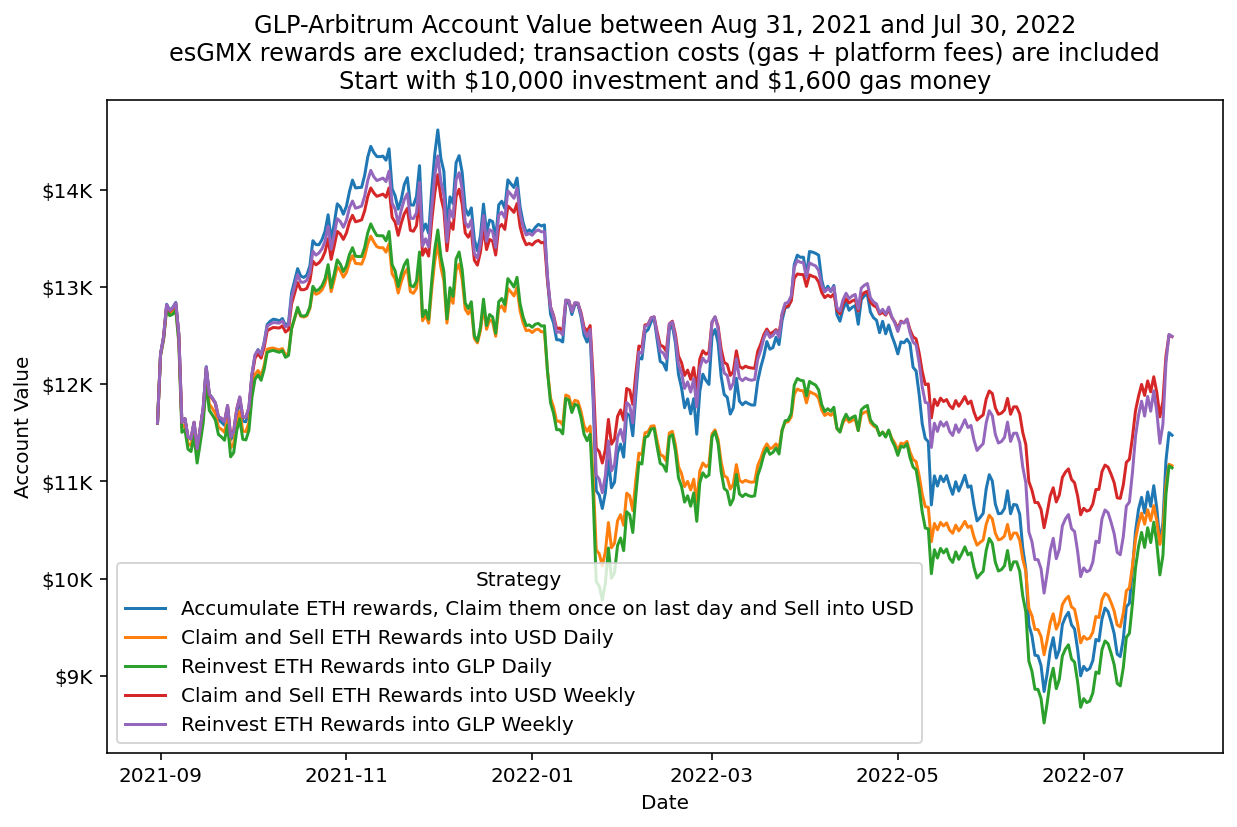

In [41]:
ax = sns.lineplot(data=df_long, x='Date', y='Account Value', hue='Strategy')
tit1 = "GLP-{} Account Value between {} and {}\n".format(chain, day1.strftime('%b %d, %Y'), end_date.strftime('%b %d, %Y'))
tit2 = "esGMX rewards are excluded; transaction costs (gas + platform fees) are included\n"
tit3 = "Start with ${:,} investment and \\${:,} gas money".format(start_capital, start_reserve)
ax.set(title= tit1 + tit2 + tit3)
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

fname = 'glp_strat_comp.png'
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);